In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
# import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
import os
import json
import folium
from folium.plugins import HeatMap
from geopy.exc import GeocoderTimedOut
import geopandas as gpd
from geopy.geocoders import Nominatim
import pysal as ps
import geojson as gj
from scipy import stats
from shapely.geometry import Polygon
from sklearn import preprocessing
import warnings
from pysal.contrib.viz import folium_mapping as fm
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [18]:
os.chdir("D:/UofT/STA2453/Project 2/Draft_Report/Data")

# Smart Parking In Toronto
<b> Anxin (Roxanne) Zhao (1004859478) | Bharadwaj Janarthanan (1005068720) | Seung Eun Yi (1005078782) </b>

# Table of Contents:

    
* [Introduction](#first-bullet)<br></br><br></br>

* [Data Collection](#second-bullet)<br></br><br></br>

* [EDA](#third-bullet)<br></br><br></br>

* [Modeling](#fourth-bullet)<br></br><br></br>

* [Next Steps](#fifth-bullet)<br></br><br></br>

# Introduction <a class="anchor" id="first-bullet"></a>


<font style="font-family:helvetica">

<p style="text-align:justify">The main problem we would like to solve is how to help municipalities optimize parking in Toronto. It can be done by reducing parking time of the vehicles at an individual level, or by finding optimal areas to place new parking locations for commercial vehicles. We decided therefore to split the problem into two main parts, one for individual vehicles and one for general organization. </p>

<p style="text-align:justify">
** For individual vehicles, we would like to look at **how we could optimize parking time**. We want to identify free parking spots, and provide an optimal route for vehicles looking for parking by defining and optimizing our own "distance" metric.
 </p>

<p style="text-align:justify">
** At a general organizational level, we want to see if **we can place new facilities to save parking time for vehicles**. We want to identify locations where the vehicles spend most time in before finding a parking spot, and look closer at how vehicle movement is different in different neighborhoods.</p>

</font>

# Data Collection <a class="anchor" id="second-bullet"></a>


 ### I. Geotab - SearchingForParking

<font style="font-family:helvetica">
    <p style="text-align:justify">
The dataset identifies areas within a city where drivers are experiencing difficulty searching for parking. The dataset includes cities with a population of more than 100,000. The project only focuses on City of Toronto. We need to use query to extract data from SearchingForParking table. 
        </p>
     <p style="text-align:justify">       
Some sample SQL code:
    </p>
    <p> 
  select * , TotalSearching/(TotalSearching/(PercentSearching)) as SearchingForParkingRatio<br></br>
  from `geotab-public-intelligence.UrbanInfrastructure.SearchingForParking`<br></br>
  where TotalSearching >= 10<br></br>
   summary = bq.Query(SQL).to_dataframe(dialect='standard')
    </p>
    </font>
    


### II. City of Toronto - Open Data

<font style="font-family:helvetica"><p style="text-align:justify">  
City of Toronto (https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/) provides several open datasets on city traffic and parking. We reviewed some relevant datasets including parking tickets, parking lot facilities, green p parking and vehicle and pedestrian volumes to see whether they are helpful to answer our questions.
    </p></font>

# Exploratory Data Analysis <a class="anchor" id="third-bullet"></a>

## I. Individual vehicles: How do we optimize parking time?

<p style="text-align:justify">In this section, we summarize findings from our initial exploration of parking in the city of Toronto and the patterns we observe </p>

### 1. How do we identify free parking spots?

To answer this question, we look at Green P Parking and On-Street parking permit areas to identify parking slots in each geoHash. We compare the total available slots to the total number of vehicles searching for parking.

In [96]:
df_gpp_geohash = pd.read_csv('../data/gpp_cleaned_except_rate_details.csv')
df_plf_geohash = pd.read_csv('../data/parking_lot_facilities_geohash.csv')

In [97]:
df_gpp_geohash.rename({'lat': 'latitude', 'lng':'longitude'}, axis=1, inplace=True)
total_parking = pd.merge(df_gpp_geohash, df_plf_geohash, how='outer', on='geohash')
total_parking.fillna(0, inplace=True)
total_parking['total_spots'] = np.maximum(total_parking['parking_spots'], total_parking['capacity'])
total_parking.rename({'geohash': 'Geohash'},axis=1, inplace=True)

In [98]:
df_geotab = pd.read_csv('../data/SearchingForParking_Toronto.csv')

In [22]:
df_merge = pd.merge(df_geotab, total_parking, how='outer', on='Geohash')[['Geohash', 'latitude', 'longitude', 'TotalSearching', 'total_spots']]
df_merge.fillna(0, inplace=True)
df_merge['geohash_simpler'] = df_merge['Geohash'].apply(lambda x: x[:5])

In [23]:
df_ratio = df_merge.groupby(['geohash_simpler'])['total_spots'].agg('sum').reset_index()
df_ratio['latitude'] = [pgh.decode_exactly(gh)[0] for gh in df_ratio['geohash_simpler'].tolist()]
df_ratio['longitude'] = [pgh.decode_exactly(gh)[1] for gh in df_ratio['geohash_simpler'].tolist()]
df_ratio['total_search'] = df_merge.groupby(['geohash_simpler'])['TotalSearching'].agg('sum').reset_index()['TotalSearching']
df_ratio['ratio'] = df_ratio['total_search'].divide(df_ratio['total_spots'])
df_ratio['ratio'] = df_ratio['ratio'].apply(lambda x: min(x, 10))

In [24]:
#### Create heatmap data
data_ratio = df_ratio[['geohash_simpler','ratio','latitude','longitude']] 
data_ratio['Value'] = data_ratio.apply(lambda row: [row.latitude, row.longitude, row.ratio], axis = 1)
heatdata_ratio = data_ratio.Value.tolist()

data_totalsearching = df_geotab[['Geohash','TotalSearching','Latitude','Longitude']] 
data_totalsearching['Value'] = data_totalsearching.apply(lambda row: [row.Latitude, row.Longitude, row.TotalSearching], axis = 1)
heatdata_totalsearching = data_totalsearching.Value.tolist()

data_capacity = total_parking[['Geohash','total_spots','latitude','longitude']] 
data_capacity['Value'] = data_capacity.apply(lambda row: [row.latitude, row.longitude, row.total_spots], axis = 1)
heatdata_capacity = data_capacity.Value.tolist()

In [25]:
#### Define map 
heatmap = folium.Map([43.6529,-79.3849], tiles='openstreetmap', zoom_start=11)
heatmap.add_children(HeatMap(heatdata_totalsearching, min_opacity =0.5, max_zoom = 18, max_val = 1,
                             radius = 15))

This heatmap shows the **distribution of cars searching for parking in Toronto**. Red areas indicate a higher number of cars searching for parking.

<p style="text-align:justify">
**Limitations** : one limitation that we have is that we do not know what the total number of cars searching for parking corresponds to - is it the total number of cars that searched for parking over the last 6 months or is it the average number of cars that search for parking every day/month/etc. ? We are stil waiting for an answer from Geotab to explain to us what this number means so that we can have a better use of this data. </p>

In [26]:
#### Define map 
heatmap_cap = folium.Map([43.6529,-79.3849], tiles='openstreetmap', zoom_start=11)
heatmap_cap.add_children(HeatMap(heatdata_capacity, min_opacity =0.5, max_zoom = 18, max_val = 1, radius=15))

This shows the **distribution of the parking spots within Toronto**. The red spots correspond to higher number of parking spots.

In [27]:
#### Define map 
heatmap_ratio = folium.Map([43.6529,-79.3849], tiles='openstreetmap', zoom_start=11)
#### 16 = 75% quantile for nb of vehicles
heatmap_ratio.add_children(HeatMap(heatdata_ratio, min_opacity =0.5, max_zoom = 18, max_val = 1,
                             radius = 20))

Here, we see the ratio between searching for parking and parking lot capacities: the higher the ratio, the higher the demand for parking. It is interesting to see that despite the fact that more parking lot capacities are placed where there are higher demand, the ratio is still higher.

### 2. What types of vehicles are present and spend the logest time searching for parking?

We first check the vehicle type distribution in each district.

In [18]:
car = df_geotab[['Geohash','PercentCar','PercentMPV','PercentLDT','PercentMDT','PercentHDT','PercentOther','District']].groupby('District').mean()

Multi-purpose Vehicles and Light Duty Vehicles have large proportion in finding parking space. While, the car has less challenge in parking.

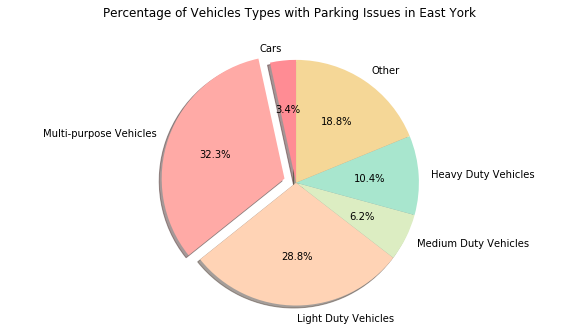

In [19]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[0]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0.1, 0, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in East York',pad = 30)
plt.show()

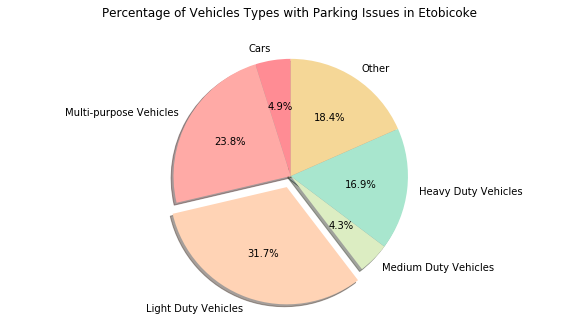

In [21]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[1]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in Etobicoke',pad = 30)
plt.show()

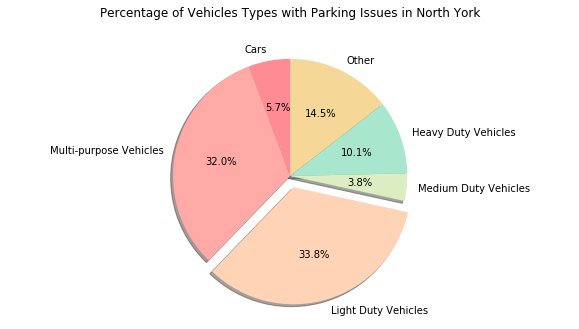

In [22]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[2]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in North York',pad = 30)
plt.show()

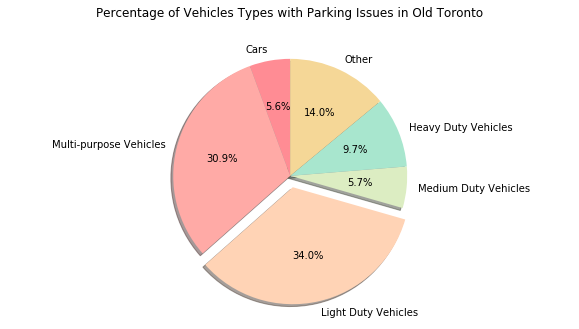

In [23]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[3]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in Old Toronto',pad = 30)
plt.show()

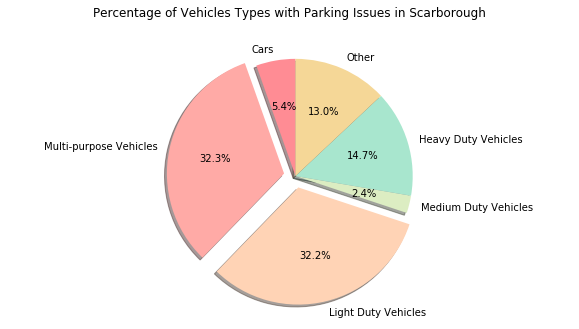

In [24]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[4]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0.1, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in Scarborough',pad = 30)
plt.show()

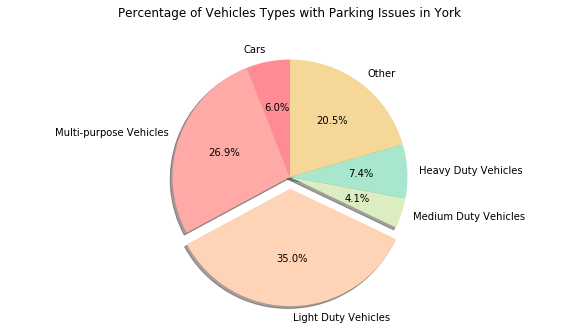

In [25]:
plt.figure(figsize=(10,5))
# The slices will be ordered and plotted counter-clockwise.
labels = 'Cars', 'Multi-purpose Vehicles', 'Light Duty Vehicles', 'Medium Duty Vehicles','Heavy Duty Vehicles','Other'
sizes = car.iloc[5]
colors = ['#FF8C94', '#FFAAA6', '#FFD3B5', '#DCEDC2','#A8E6CE','#F5D797']
explode = (0, 0, 0.1, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Percentage of Vehicles Types with Parking Issues in York',pad = 30)
plt.show()

## II. General organization: Where to place new parking facilities?

### 1. How does the average parking time vary for different districts?

The catplot gragh shows the average parking time comparing between each district. The average time in Old Toronto Area is around 6 mins.

<Figure size 720x360 with 0 Axes>

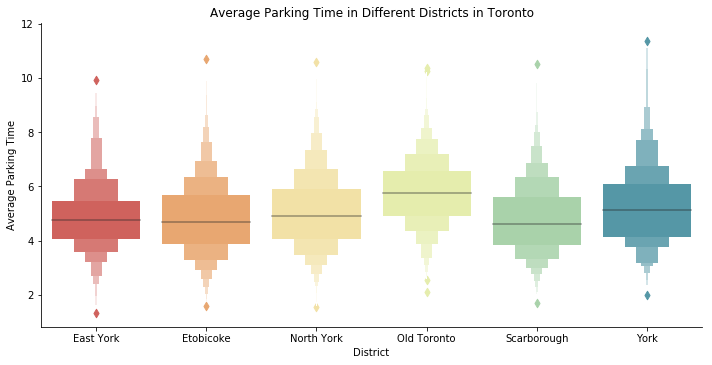

In [17]:
plt.figure(figsize=(10,5))
sns.catplot(x="District", y="AvgTimeToPark", kind="boxen",data=df_geotab.sort_values("District"),palette="Spectral",height=5,aspect=2)
plt.title('Average Parking Time in Different Districts in Toronto')
plt.xlabel('District')
plt.ylabel('Average Parking Time')
plt.show()

### 2. Which are the locations the vehicles spend most time in before finding a parking spot? 

<p style="text-align:justify">
This question can be tackled in two ways:
<br></br>
<br></br>
* **Issue Count Analysis**: the issue count is the count of parking geohashes in the city that have the percentage of vehicles searching for parking equal to or above the city average (based on the percentage of vehicles searching for parking from the Geotab data)
<br></br>
<br></br>
* **Circling distribution analysis**: the circling distribution will indicate the geohashes vehicles explore before parking and how long they spend in each neighboring geohash.
</p>

#### 2.a. Issue Count Analysis :

Shown below is Geotab Searching Parking dataset.

In [28]:
df_geotab.drop(df_geotab.columns[[7,8,9,10,11,27,28]], axis=1, inplace=True)
df_geotab.head()

,Geohash,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Latitude,Longitude,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,...,AvgTotalGeohashes,CirclingDistribution,HourlyDistribution,SearchingByHour,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,PercentOther
0,dpz2nth,43.62122,-79.51355,43.62259,-79.51218,43.62203,-79.51279,4.2656,1.4406,32,...,11.2500,"{""dpz2ntm"":0.1646, ""dpz2ntj"":0.0556, ""dpz2nt7""...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...",0.0000,0.1563,0.4375,0.0938,0.2188,0.0938
1,dpz2pnp,43.62671,-79.48746,43.62808,-79.48608,43.62777,-79.48653,6.5115,1.1102,58,...,9.5172,"{""dpz2pq0"":0.1145, ""dpz2pnp"":0.2925, ""dpz2pmb""...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...",0.0000,0.0000,0.0172,0.0000,0.8621,0.1207
2,dpz9k90,43.81897,-79.25537,43.82034,-79.25400,43.81917,-79.25500,4.4358,1.3241,40,...,7.2000,"{""dpz9k90"":0.3395, ""dpz9k8c"":0.0621, ""dpz9k3p""...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...",0.0000,0.0250,0.6000,0.0500,0.3250,0.0000
3,dpz95wt,43.80524,-79.29245,43.80661,-79.29108,43.80573,-79.29157,3.1831,1.0765,59,...,7.4407,"{""dpz95wv"":0.0873, ""dpz95ws"":0.0597, ""dpz95wq""...","{""00"": 0.0478, ""01"": 0, ""02"": 0.0478, ""03"": 0....","{""00"": 0.3333, ""01"": 0, ""02"": 0.1667, ""03"": 0....",0.1186,0.2542,0.2712,0.0000,0.3559,0.0000
4,dpz2jsn,43.61572,-79.55475,43.61710,-79.55338,43.61657,-79.55445,6.5225,1.6573,37,...,9.2973,"{""dpz2jez"":0.215, ""dpz2jsr"":0.0392, ""dpz2jsj"":...","{""00"": 0.0667, ""01"": null, ""02"": null, ""03"": 0...","{""00"": 0.4, ""01"": null, ""02"": null, ""03"": 0, ""...",0.0270,0.0811,0.5946,0.0270,0.1622,0.1081


Find the city average, only consider those geohashes have greater than 10 total searching.

In [10]:
AvgThreshold = df_geotab[df_geotab.TotalSearching > 10].PercentSearching.mean()
print("The average threshold is: ", str(AvgThreshold))

The average threshold is:  0.11617007779772566


We can define a parking lot that has parking issue when the searching time is larger than average.

In [6]:
df_issue = df_geotab[df_geotab.PercentSearching > AvgThreshold]

In [7]:
data = df_issue[['Geohash','PercentSearching','Latitude','Longitude']]
data['Value'] = data.apply(lambda row:[row.Latitude,row.Longitude,(row.PercentSearching-AvgThreshold)/0.1],axis = 1)
heatdata = data.Value.tolist()

We can then divide geohashes into six districts using geocode to convert coordinate to address

In [8]:
def re_geocode(coord):
    try:
        location = geolocator.reverse(coord,timeout = 10)
        return location.address.split(",")[-5]
    except GeocoderTimedOut:
        return re_geocode(coord)

In [ ]:
geolocator = Nominatim(user_agent="geotab")
district = []
for index, row in df_geotab.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    coord = "{},{}".format(lat,lon)
    dis = re_geocode(coord)
    district.append(dis)

In [10]:
# df_geotab['District'] = district
# df_geotab['District'] = df_geotab['District'].str.strip()
df_geotab = pd.read_csv("../data/SearchingParkingDistrict.csv")
df_geotab.head()

,Unnamed: 0,Geohash,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Latitude,Longitude,AvgTimeToPark,AvgTimeToParkRatio,...,CirclingDistribution,HourlyDistribution,SearchingByHour,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,PercentOther,District
0,0,dpz2nth,43.62122,-79.51355,43.62259,-79.51218,43.62203,-79.51279,4.2656,1.4406,...,"{""dpz2ntm"":0.1646, ""dpz2ntj"":0.0556, ""dpz2nt7""...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...","{""00"": null, ""01"": 0, ""02"": null, ""03"": null, ...",0.0000,0.1563,0.4375,0.0938,0.2188,0.0938,Etobicoke
1,1,dpz2pnp,43.62671,-79.48746,43.62808,-79.48608,43.62777,-79.48653,6.5115,1.1102,...,"{""dpz2pq0"":0.1145, ""dpz2pnp"":0.2925, ""dpz2pmb""...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...","{""00"": 0, ""01"": 0, ""02"": 0, ""03"": 0, ""04"": 0, ...",0.0000,0.0000,0.0172,0.0000,0.8621,0.1207,Etobicoke
2,2,dpz9k90,43.81897,-79.25537,43.82034,-79.25400,43.81917,-79.25500,4.4358,1.3241,...,"{""dpz9k90"":0.3395, ""dpz9k8c"":0.0621, ""dpz9k3p""...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...","{""00"": 0, ""01"": 0, ""02"": null, ""03"": 0, ""04"": ...",0.0000,0.0250,0.6000,0.0500,0.3250,0.0000,Scarborough
3,3,dpz95wt,43.80524,-79.29245,43.80661,-79.29108,43.80573,-79.29157,3.1831,1.0765,...,"{""dpz95wv"":0.0873, ""dpz95ws"":0.0597, ""dpz95wq""...","{""00"": 0.0478, ""01"": 0, ""02"": 0.0478, ""03"": 0....","{""00"": 0.3333, ""01"": 0, ""02"": 0.1667, ""03"": 0....",0.1186,0.2542,0.2712,0.0000,0.3559,0.0000,Scarborough
4,4,dpz2jsn,43.61572,-79.55475,43.61710,-79.55338,43.61657,-79.55445,6.5225,1.6573,...,"{""dpz2jez"":0.215, ""dpz2jsr"":0.0392, ""dpz2jsj"":...","{""00"": 0.0667, ""01"": null, ""02"": null, ""03"": 0...","{""00"": 0.4, ""01"": null, ""02"": null, ""03"": 0, ""...",0.0270,0.0811,0.5946,0.0270,0.1622,0.1081,Etobicoke


By counting the number of geohashes in each district, we get:

In [11]:
df_geotab.groupby('District')['Geohash'].count()

District
East York       113
Etobicoke       609
North York      776
Old Toronto    1469
Scarborough     593
York            171
Name: Geohash, dtype: int64

Then we can count the number of issues in each district:

In [11]:
df_dis = df_geotab.groupby('District')['PercentSearching'].apply(lambda x: (x > AvgThreshold).sum()).reset_index(name='IssueCount')
df_dis

,District,IssueCount
0,East York,44
1,Etobicoke,217
2,North York,287
3,Old Toronto,425
4,Scarborough,249
5,York,77


The bar plot below shows 6 districts ranked by the issue count:

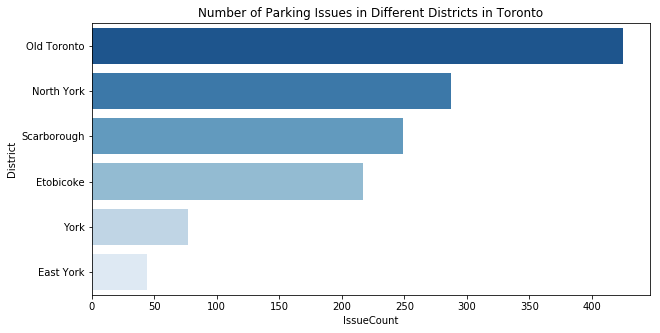

In [13]:
df_dis = df_dis.sort_values('IssueCount',ascending = False)
plt.figure(figsize=(10,5))
sns.barplot(x = df_dis.IssueCount,y = df_dis.District,data = df_dis, palette="Blues_r")
plt.title('Number of Parking Issues in Different Districts in Toronto')
plt.xlabel('IssueCount')
plt.ylabel('District')
plt.show()

We can also create a choropleth map to show the issue count in each district:

In [ ]:
shp = ps.open('../data/cityprj_former_municipality.shp')
dbf = ps.open('../data/cityprj_former_municipality.dbf')
city = fm.build_features(shp, dbf)

In [32]:
gdf = gpd.read_file("city.json")
gdf

,AREA_ID,AREA_NAME,OBJECTID,style,highlight,geometry
0,49884,YORK,11093905,"{'weight': 1, 'opacity': 0.7, 'color': 'black'...",{},"POLYGON ((305379.358 4833944.091, 305390.086 4..."
1,643704,NORTH YORK,11678465,"{'weight': 1, 'opacity': 0.7, 'color': 'black'...",{},"POLYGON ((301896.125 4840686, 301890.593 48406..."
2,49887,EAST YORK,12266929,"{'weight': 1, 'opacity': 0.7, 'color': 'black'...",{},"POLYGON ((321894.218 4838669.741, 321786.825 4..."
3,435733,SCARBOROUGH,12852625,"{'weight': 1, 'opacity': 0.7, 'color': 'black'...",{},"POLYGON ((321894.218 4838669.741, 321880.575 4..."
4,1094349,ETOBICOKE,14035025,"{'weight': 1, 'opacity': 0.7, 'color': 'black'...",{},"POLYGON ((306265.375 4830753.5, 306252.937 483..."
5,760645,TORONTO,14035041,"{'weight': 1, 'opacity': 0.7, 'color': 'black'...",{},"POLYGON ((313135.18 4831158.463, 313108.531 48..."


In [33]:
df_dis['AREA_NAME'] = df_dis['District'].str.upper()
df_dis['AREA_NAME'][3] = "TORONTO"
df_dis

,District,IssueCount,AREA_NAME
0,East York,44,EAST YORK
1,Etobicoke,217,ETOBICOKE
2,North York,287,NORTH YORK
3,Old Toronto,425,TORONTO
4,Scarborough,249,SCARBOROUGH
5,York,77,YORK


In [34]:
m = folium.Map([43.6798, -79.4252], zoom_start = 12, tiles='openstreetmap')
folium.LatLngPopup().add_to(m)

In [35]:
folium.Choropleth(
 geo_data = gdf,
 data = df_dis,
 columns=['AREA_NAME', 'IssueCount'],
 key_on='feature.properties.AREA_NAME',
 fill_color='YlGn',
 fill_opacity=0.5,
 line_opacity=0.7,
 legend_name='Parking Issue Count in Toronto'
).add_to(m)

In [36]:
from folium.features import DivIcon
folium.map.Marker(
    [43.6499, -79.4288],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">Old Toronto</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.6683, -79.5900],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">Etobicoke</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.7516, -79.4864],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">North York</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.7938, -79.2812],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">Scarborough</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.6916, -79.4960],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">York</div>',
        )
    ).add_to(m)
folium.map.Marker(
    [43.7055, -79.3643],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-family: Comic Sans MS; font-size: 18pt">East York</div>',
        )
    ).add_to(m)

The dark green means more parking issues. Old Toronto Area has bigger challenge in searching parking.

In [3]:
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=./city_data.html width=780 height=550></iframe>')

The heatmap shows the difference between percent driving and average threshold

In [ ]:
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 3,radius = 17).add_to(m)
m.save('plot_data.html')

In [2]:
# Import the Folium interactive html file
from IPython.display import HTML
HTML('<iframe src=./plot_data.html width=780 height=550></iframe>')

#### 2.b. Circling distribution analysis:

##### 2.b.1 What's the average time spent in parking in a neighborhood geohash for a vehicle?

In [62]:
#Subsetting only for Circling Distribution Exploration
geoTabCircleDat=df_geotab[['Geohash','AvgTimeToPark','PercentSearching','CirclingDistribution']]

In [63]:
#Convert JSON string to dictionary
CirclingDistListDict = geoTabCircleDat.CirclingDistribution.apply(json.loads).values.tolist()

In [64]:
#Create dataframe of Circling distribution
geoCircleDict={"parkGeoHash":[],"spendGeoHash":[],"pctTimeSpend":[],"AvgTimeToPark":[],"PercentSearching":[]}
i=0
for geoCircle in CirclingDistListDict:
    geoCircleDict["parkGeoHash"].extend([geoTabCircleDat["Geohash"][i]]*len(geoCircle.keys()))
    geoCircleDict["spendGeoHash"].extend(list(geoCircle.keys()))
    geoCircleDict["pctTimeSpend"].extend(list(geoCircle.values()))
    geoCircleDict["AvgTimeToPark"].extend([geoTabCircleDat["AvgTimeToPark"][i]]*len(geoCircle.keys()))
    geoCircleDict["PercentSearching"].extend([geoTabCircleDat["PercentSearching"][i]]*len(geoCircle.keys()))
    i+=1
geoCircleDat=pd.DataFrame(geoCircleDict)

In [65]:
#This table shows us, how many different park neighborhoods does a vehicle spending most time in a spend neighborhood can go into and the average parking time of these park geohashes
#idx = geoCircleDat.groupby(['parkGeoHash'])['pctTimeSpend'].transform(max) == geoCircleDat['pctTimeSpend']
geoCircleDatAgg=geoCircleDat.groupby(["spendGeoHash"],as_index=False).agg({'parkGeoHash':'nunique','AvgTimeToPark':'mean'})
geoCircleDatAgg=geoCircleDat.groupby(["spendGeoHash"],as_index=False).agg({'parkGeoHash':'nunique','AvgTimeToPark':'mean'})

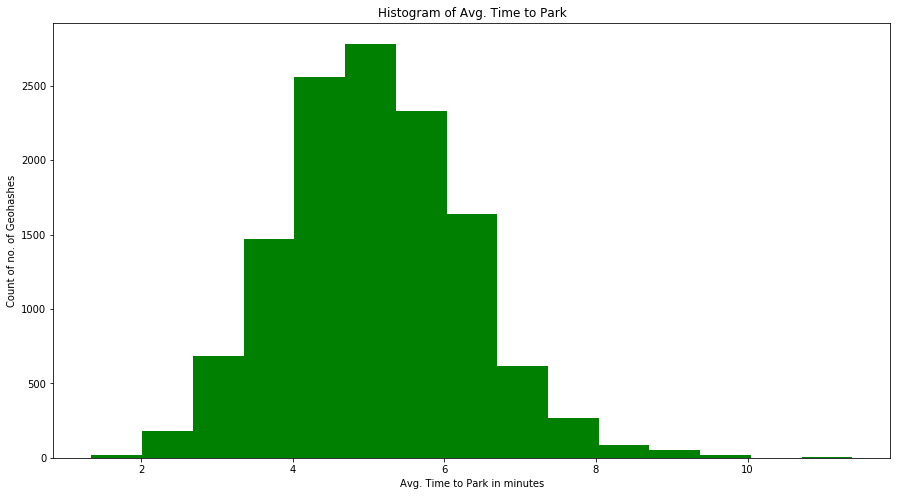

In [66]:
#Histogram of Avg. Parking time per park neighborhood
plt.figure(figsize=(15,8))
plt.hist(geoCircleDatAgg["AvgTimeToPark"],color="g",bins=15);
plt.xlabel("Avg. Time to Park in minutes");
plt.ylabel("Count of no. of Geohashes");
plt.title("Histogram of Avg. Time to Park");

Most vehicles spend 4-6 mins on an average in finding a parking spot at neighbor geohashes.

##### 2.b.2.  What's the average number of neighorhood geohashes vehicles drive to find a parking?

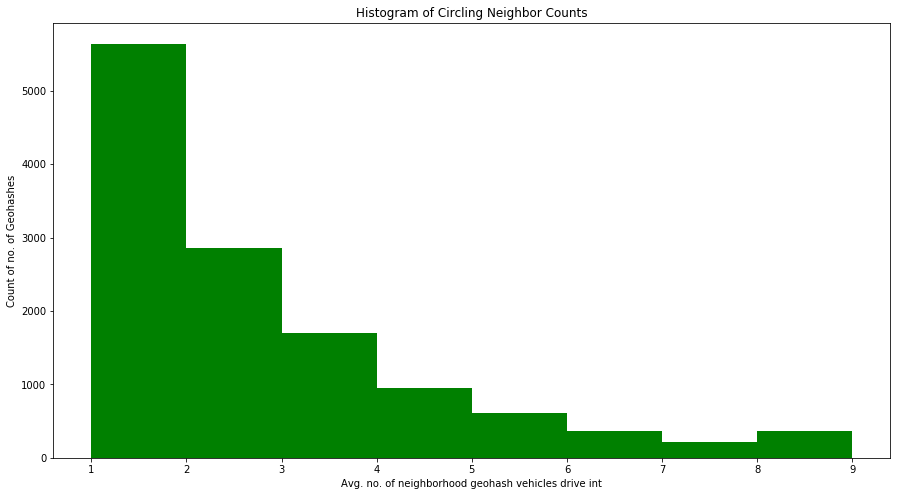

In [67]:
#Histogram of, # of different neighborhoods into which vehicles park at from a specific neighborhood 
plt.figure(figsize=(15,8))
plt.hist(geoCircleDatAgg["parkGeoHash"],color="g",bins=8);
plt.xlabel("Avg. no. of neighborhood geohash vehicles drive int");
plt.ylabel("Count of no. of Geohashes");
plt.title("Histogram of Circling Neighbor Counts");

Most vehicles find a parking spot within circling upto two different neighborhoods. However, a fewer number of locations require vehicles to circle more than five different neighborhhods

##### 2.b.3.  Is parking time more on neighborhoods than on own geohash?

For the purpose of this analysis, we only compare the average parking time across all different neighborhoods,vehicles at a specific geohas has driven to park and compare that against the 6 month average parking time for own geohash parking.

<b>Parking Index= (Avg. Neighborhood GeoHash Avg. Parking Time)/(Avg. Current GeoHash Parking Time)</b>

Note: For the purpose of the heatmap visualisation, we highlight every geohash with more than average ratio across the city.

In [37]:
geoCircleParkDatAgg=df_geotab.groupby(["Geohash"],as_index=False).agg({'AvgTimeToPark':'mean'})
geoCircleParkDatAgg.columns=["spendGeoHash","avgTimeToPark_parkGeoHash"]

In [38]:
geoCircleDatAgg['spend_lat'] = geoCircleDatAgg.apply(lambda row: pgh.decode(row.spendGeoHash)[0], axis = 1)
geoCircleDatAgg['spend_lng'] = geoCircleDatAgg.apply(lambda row: pgh.decode(row.spendGeoHash)[1], axis = 1)
geoCircleDatAgg=geoCircleDatAgg.merge(geoCircleParkDatAgg,on=['spendGeoHash'])

In [39]:
geoCircleDatAgg.columns=['spendGeoHash','no_of_parkGeoHash','avgParkTime_parkGeoHash','spend_lat','spend_lng','avgTimeToPark_spendGeoHash']

In [43]:
#geoCircleDatAgg.head()

In [44]:
cmprParkTimeDat=geoCircleDatAgg[geoCircleDatAgg["avgTimeToPark_spendGeoHash"].notnull()]
cmprParkTimeDat['ownToNeighParkTimeIndex']=cmprParkTimeDat['avgParkTime_parkGeoHash']/cmprParkTimeDat['avgTimeToPark_spendGeoHash']

In [45]:
cmprParkTimeDat.head()

,spendGeoHash,no_of_parkGeoHash,avgParkTime_parkGeoHash,spend_lat,spend_lng,avgTimeToPark_spendGeoHash,ownToNeighParkTimeIndex
0,dpxrvzm,4,3.631550,43.59,-79.54,2.5233,1.439207
1,dpxrvzs,2,4.266050,43.59,-79.55,4.1580,1.025986
2,dpxrvzt,4,3.631550,43.59,-79.54,4.3741,0.830239
3,dpxrvzw,4,4.185500,43.59,-79.54,3.4708,1.205918
4,dpxrvzz,3,4.358967,43.59,-79.54,6.3738,0.683888


In [46]:
cmprParkTimeDat['ownToNeighParkTimeIndex_scaled']=(cmprParkTimeDat.ownToNeighParkTimeIndex-cmprParkTimeDat.ownToNeighParkTimeIndex.mean())/cmprParkTimeDat.ownToNeighParkTimeIndex.std()

In [50]:
# Create heatmap data
geoCirclehtMpDat = cmprParkTimeDat[['spendGeoHash','avgParkTime_parkGeoHash','spend_lat','spend_lng']]
geoCirclehtMpDat['avgParkTime_parkGeoHash_scaled']=(geoCirclehtMpDat['avgParkTime_parkGeoHash']-geoCirclehtMpDat['avgParkTime_parkGeoHash'].mean())/geoCirclehtMpDat['avgParkTime_parkGeoHash'].std()
geoCirclehtMpDat['Value'] = geoCirclehtMpDat.apply(lambda row: [row.spend_lat, row.spend_lng, row.avgParkTime_parkGeoHash_scaled], axis = 1)
heatdata = geoCirclehtMpDat.Value.tolist() # a list of lists: [[latitude, longitude, avg_per_neighbrohood],...]

# Define map 
heatmap = folium.Map([45.418167,-75.690994], tiles='openstreetmap', zoom_start=6)

# Plot Geohash Markers
Markers = folium.FeatureGroup(name='Heat Map of Avg. Time to Park in Neighborhood"')

# Plot heatmap based on the Searching for Parking Index
index = folium.FeatureGroup(name='Geohash- Avg. Per Neigh')
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 1 ,radius=15).add_to(index) 
index.add_to(heatmap)
heatmap

From the above heatmap, we observe that old Toronto geohashes have higher parking time even around their own neighborhood

**Average Parking Index Ratio:**

As can be seen in most neighborhoods, vehicles spend as much time parking in circling area, as they would in currnet geohash zone.

In [52]:
cmprParkTimeDat.ownToNeighParkTimeIndex.mean()

1.0316262099592115

In [51]:
# Define map 
heatmap = folium.Map([45.418167,-75.690994], tiles='openstreetmap', zoom_start=6)

# Create heatmap data
cmprParkTimeHtMpDat = cmprParkTimeDat[['spendGeoHash','ownToNeighParkTimeIndex_scaled','spend_lat','spend_lng']]
cmprParkTimeHtMpDat['Value'] = cmprParkTimeHtMpDat.apply(lambda row: [row.spend_lat, row.spend_lng, row.ownToNeighParkTimeIndex_scaled], axis = 1)
heatdata = cmprParkTimeHtMpDat.Value.tolist() # a list of lists: [[latitude, longitude, avg_per_neighbrohood],...]

# Plot heatmap based on the Searching for Parking Index
OwnNeighborindex = folium.FeatureGroup(name='Own Vs Neighborhood Parking Index-GeoHash Level')
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 1 ,radius=15).add_to(OwnNeighborindex) 
OwnNeighborindex.add_to(heatmap)

# Add all the layers (feature groups) onto the map
folium.LayerControl().add_to(heatmap)
heatmap

In [53]:
# Compare to see if the difference in the two parking times are statistically significant
f_value, p_value = stats.f_oneway(cmprParkTimeDat['avgParkTime_parkGeoHash'],cmprParkTimeDat['avgTimeToPark_spendGeoHash'])

In [54]:
p_value

0.8428638371750574

A F-Test to test for difference between the park time in own and neighborhood zones suggest that the differences if any is not statistically signifcant

In [68]:
geoCircleDat.columns=['parkGeoHash','spendGeoHash','pctTimeSpend','parkGeoHash_AvgTimeToPark','parkGeoHash_PercentSearching']

In [69]:
geoTabCircleDat=df_geotab[['Geohash','AvgTimeToPark','PercentSearching']]

In [70]:
geoTabCircleDat.columns=['spendGeoHash','spendGeoHash_AvgTimeToPark','spendGeoHash_PercentSearching']

In [71]:
#geoCircleDat['spendGeoHash'].values

In [72]:
geoCircleDat = geoCircleDat.merge(geoTabCircleDat,on='spendGeoHash')

In [74]:
def find_distance(x):
    return pgh.geohash_approximate_distance(x[0],x[1])
geoCircleDat['distance']=geoCircleDat.apply(find_distance,axis=1)

In [75]:
#Decode Spend Geohash into latitude and longitude
geoCircleDat=pd.DataFrame(geoCircleDat)
geoCircleDat['spend_lat'] = geoCircleDat.apply(lambda row: pgh.decode(row.spendGeoHash)[0], axis = 1)
geoCircleDat['spend_lng'] = geoCircleDat.apply(lambda row: pgh.decode(row.spendGeoHash)[1], axis = 1)
geoCircleDat['park_lat'] = geoCircleDat.apply(lambda row: pgh.decode(row.parkGeoHash)[0], axis = 1)
geoCircleDat['park_lng'] = geoCircleDat.apply(lambda row: pgh.decode(row.parkGeoHash)[1], axis = 1)

In [77]:
food_shop_count=pd.read_csv("../data/Total food shop count.csv")

In [78]:
food_shop_count=food_shop_count[['Geohash','District','food_count','shop_count']].drop_duplicates(keep=False)

In [79]:
food_shop_count.columns=['spendGeoHash','spendDistrict','spendFoodC','spendShopC']
geoCircleDat=geoCircleDat.merge(food_shop_count,on='spendGeoHash')
food_shop_count.columns=['parkGeoHash','parkDistrict','parkFoodC','parkShopC']
geoCircleDat=geoCircleDat.merge(food_shop_count,on='parkGeoHash')
food_shop_count.columns=['Geohash','District','FoodC','ShopC']
geoTabDat=df_geotab.merge(food_shop_count,on='Geohash')

In [80]:
geoCircleDat.head()

,parkGeoHash,spendGeoHash,pctTimeSpend,parkGeoHash_AvgTimeToPark,parkGeoHash_PercentSearching,spendGeoHash_AvgTimeToPark,spendGeoHash_PercentSearching,distance,spend_lat,spend_lng,park_lat,park_lng,spendDistrict,spendFoodC,spendShopC,parkDistrict,parkFoodC,parkShopC
0,dpz2nth,dpz2ntm,0.1646,4.2656,0.2645,4.1833,0.1200,610,43.62,-79.51,43.62,-79.51,Etobicoke,9,8,Etobicoke,2,3
1,dpz2nth,dpz2nt7,0.2464,4.2656,0.2645,5.0130,0.2000,610,43.62,-79.51,43.62,-79.51,Etobicoke,5,5,Etobicoke,2,3
2,dpz2nth,dpz2nth,0.1904,4.2656,0.2645,4.2656,0.2645,118,43.62,-79.51,43.62,-79.51,Etobicoke,2,3,Etobicoke,2,3
3,dpz2ntw,dpz2ntm,0.0938,4.6771,0.0500,4.1833,0.1200,610,43.62,-79.51,43.62,-79.51,Etobicoke,9,8,Etobicoke,15,11
4,dpz2ntw,dpz2ntq,0.0317,4.6771,0.0500,4.3179,0.1327,610,43.62,-79.51,43.62,-79.51,Etobicoke,2,12,Etobicoke,15,11


#### 3. Will placing new parking facilities really result in decreasing the average searching for parking time ?

In [83]:
df_plf = pd.read_csv('parking_lot_facilities_geohash.csv')

In [84]:
df_geotab = df_geotab.rename({'Geohash': 'geohash'}, axis=1)
df_merged = pd.merge(df_geotab, df_plf, on=['geohash'])

LinregressResult(slope=-0.002555056022344729, intercept=5.2255772982461774, rvalue=-0.18701907819383354, pvalue=0.4169350515824565, stderr=0.003078979100875691)

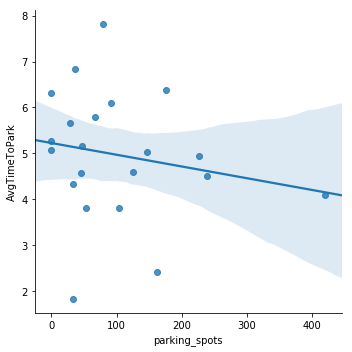

In [87]:
sns.lmplot(x='parking_spots', y='AvgTimeToPark', data=df_merged)
stats.linregress(df_merged['parking_spots'], df_merged['AvgTimeToPark'])

In this case, we can decide to remove the point at the rightmost part of the graph (seems like a outlier, having a very high number of parking spots).

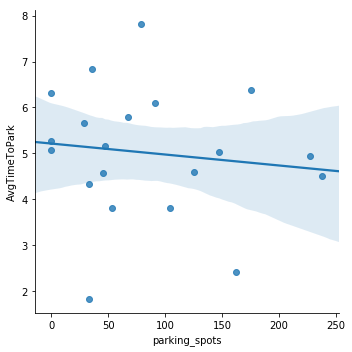

In [88]:
df_merged2 = df_merged[~df_merged.index.isin([11])]
sns.lmplot(x='parking_spots', y='AvgTimeToPark', data=df_merged2)

In [89]:
stats.linregress(df_merged2['parking_spots'], df_merged2['AvgTimeToPark'])

LinregressResult(slope=-0.002387964307803153, intercept=5.213952382224757, rvalue=-0.12284495290362585, pvalue=0.6058778031731202, stderr=0.004547077323085025)

** Conclusion: ** In both cases, we can see that the results are not significant enough to conclude that more parking spots do not lead to a lower average parking time. We also looked at what happens when aggregating at a 6-character level.

#### 4. How does the park time vary with the number of businesses in a location?

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">It can be seen that with increasing number of food and shop services in a location, the avg. time  to find a parking spot in the location</font></p>

<b><font size="2" style="font-family:helvetica"> Extracting Geo-Location Potential Traffic Volume:</font></b>

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica"> In order to find how busy a Geohash can possibly be, we extract the number of Food category- Coffee Shops and Restaurants are ata specific Geohash, we believe these features would serve as a proxy to how busy a Geohash can be in Pedestrain and Vehical Volume. Thereby, suggesting the likelihood of finding parking spot in that area and the time taken to find one. We extract the food and shopping services available within 200m of a geo-hash</font></p>

In [113]:
df_geotab = pd.read_csv("../data/SearchingParkingDistrict.csv")
df_geotab.set_index('Geohash');
gis = GIS()

In [114]:
geocode_fs = geocode(address=None,
                    location=[-79.3983,43.6525],
                    category="Food",
                    out_fields="Place_addr, PlaceName, Distance",
                    as_featureset=True,max_locations=40)

In [115]:
g_df = geocode_fs.df

In [124]:
data = pd.read_csv("Total food shop count.csv")

In [116]:
g_map = gis.map([43.6525,-79.3983], zoomlevel=20)
g_map.basemap = 'satellite'
g_map.draw(geocode_fs,symbol= geocode_fs)

In [117]:
#Shops and services around a location (200 meter range)
geocode_fs = geocode(address=None,
                    location=[-79.3983,43.6525],
                    category="Shops and Service",
                    out_fields="Place_addr, PlaceName, Distance",
                    as_featureset=True,max_locations=40)

In [118]:
g_df = geocode_fs.df

In [119]:
df_ot = df_geotab.loc[(df_geotab['District'] != "Old Toronto")]

In [120]:
#Find the number of restaurants and shops within 200m of a location
shop_count = []
for index, row in df_ot.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    geocode_fs = geocode(address=None,
                    location=[lon,lat],
                    category="Shops and Service",
                    out_fields="Place_addr, PlaceName, Distance",
                    as_featureset=True,max_locations=40)
    g_df = geocode_fs.df
    count = g_df.loc[(g_df['Distance'] <= 200)].shape[0]
    shop_count.append(count)

In [121]:
food_count = []
for index, row in df_ot.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    geocode_fs = geocode(address=None,
                    location=[lon,lat],
                    category="food",
                    out_fields="Place_addr, PlaceName, Distance",
                    as_featureset=True,max_locations=40)
    g_df = geocode_fs.df
    count = g_df.loc[(g_df['Distance'] <= 200)].shape[0]
    food_count.append(count)

In [125]:
df_ot['food_count'] = food_count
df_ot['shop_count'] = shop_count

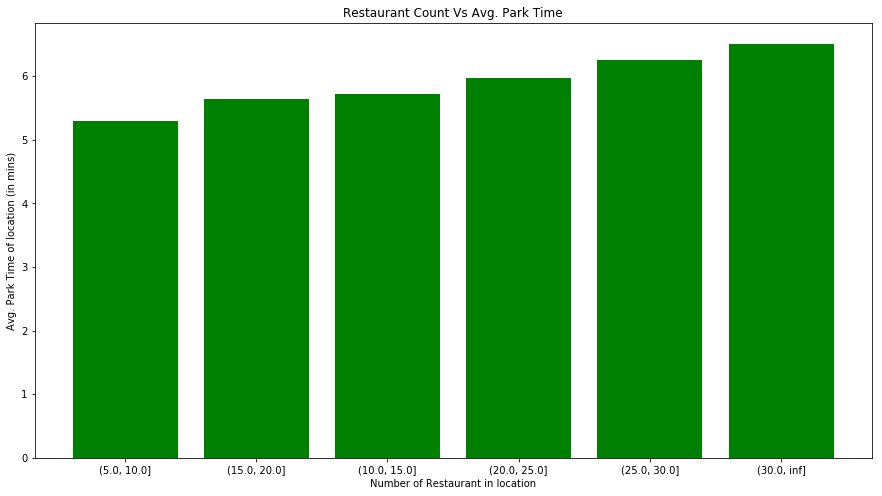

In [126]:
plt.figure(figsize=(15,8))
bins = [5,10,15,20,25,30, np.inf]
labels = [f'{i}+' if j==np.inf else f'{i}-{j}' for i, j in zip(bins, bins[1:])]
data['food_count_range'] = pd.cut(data['food_count'], bins, labels)
data['food_count_range'] = data['food_count_range'].astype(str)
agg_dat=data[data['food_count_range']!="nan"].groupby('food_count_range',as_index=False).agg({'AvgTimeToPark':'mean'})
agg_dat=agg_dat.sort_values("AvgTimeToPark")
plt.bar(agg_dat['food_count_range'],agg_dat['AvgTimeToPark'],color="g");
plt.title('Restaurant Count Vs Avg. Park Time');
plt.ylabel('Avg. Park Time of location (in mins)');
plt.xlabel("Number of Restaurant in location");

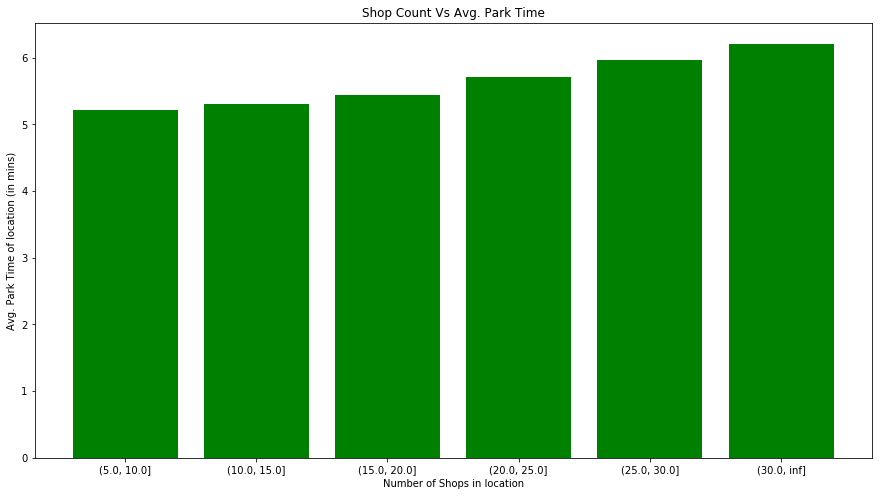

In [127]:
plt.figure(figsize=(15,8))
bins = [5,10,15,20,25,30, np.inf]
labels = [f'{i}+' if j==np.inf else f'{i}-{j}' for i, j in zip(bins, bins[1:])]
data['shop_count_range'] = pd.cut(data['shop_count'], bins, labels)
data['shop_count_range'] = data['shop_count_range'].astype(str)
agg_dat=data[data['shop_count_range']!="nan"].groupby('shop_count_range',as_index=False).agg({'AvgTimeToPark':'mean'})
agg_dat=agg_dat.sort_values("AvgTimeToPark")
plt.bar(agg_dat['shop_count_range'],agg_dat['AvgTimeToPark'],color="g");
plt.title('Shop Count Vs Avg. Park Time');
plt.ylabel('Avg. Park Time of location (in mins)');
plt.xlabel("Number of Shops in location");

### 5. Which factors are strongly correlated with avg. parking time?

<p style="text-align:justify"><font size="3" style="font-family:helvetica">In this exploration, we try to find significant factors that influence avg. park time in a Geohash. The identified signifcant features would then feed into our individual optimization algorithm to find Geohash to ideally find a parking spot at in minimal time.<font></p>

In [128]:
df_cap = pd.read_csv("TO_TRAFFIC_PEDESTRIAN_8HRVOL_GEOHASH_X_DAY.csv")
df_cap.drop(df_cap.columns[[0]],axis=1, inplace=True)
df_cap.set_index('geo_hash');

In [129]:
data.set_index('Geohash')
data.drop(data.columns[[0]],axis=1, inplace=True)
result = pd.merge(data,df_cap,left_on='Geohash',right_on='geo_hash',how='left')

In [130]:
df_cor = result[result.geo_hash.notnull()][['AvgTimeToPark','TotalSearching', 'PercentSearching',
       'AvgUniqueGeohashes', 'AvgTotalGeohashes','PercentCar','PercentMPV','PercentLDT','PercentMDT','PercentHDT','PercentOther','food_count','shop_count','8hr_Vehicle_Vol','8hr_Pedestrian_Vol']]
corr = df_cor.corr(method ='pearson')

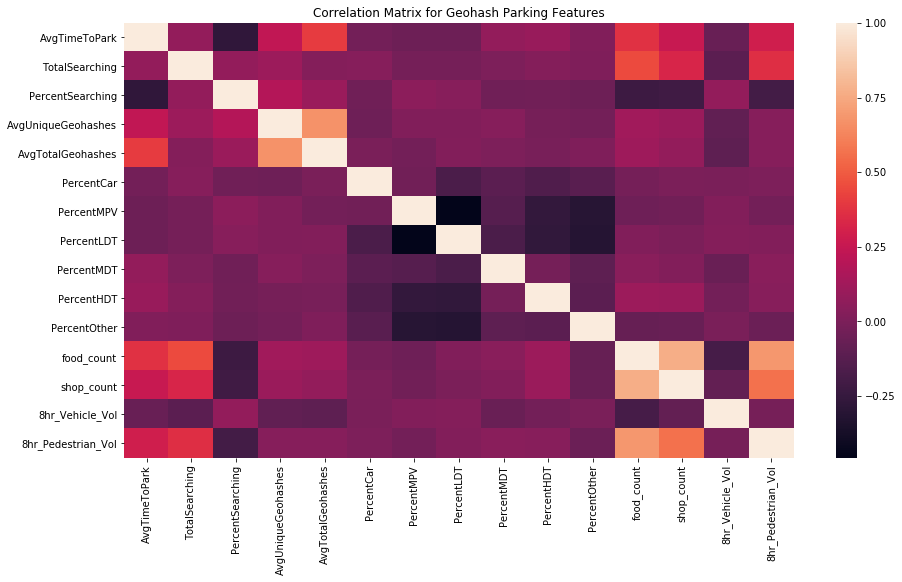

In [131]:
plt.figure(figsize=(15,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title("Correlation Matrix for Geohash Parking Features")
plt.show()

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">The correlation heatmap shows that, percentage vehicles searching for parking has a negative relationship to the average parking time while the total unique geohashes that a vehicle visits before parking at a geohash, and the total geohashes vehicles visit before parking on a Geohash, number of food services, number of shops and daily pedestrian volume have a positive relationship with average parking time.</font></p>

# Modelling: <a class="anchor" id="fourth-bullet"></a>

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">In this section of the report, we explain different statistical techniques and machine learning models developed to identify which factors influence parking time in a GeoHash. Based onn our understanding of different features and data from the exploratory analysis we explore statistical significance of different features with Avg. Parking time in each GeoHash</font></p>

### I. Individual Vehicles: How do we optimize parking time?

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">In this section, as an initial effort we attempt to build rank based system to suugest best available geohash to find a parking spot given, the current geohash location. The features used in the rule based system was based on the model identified in the General organization random forest model explained in the following sub-section.</font></p>

In [132]:
def findPArkGeoHash(spendGeoHash):
    
    '''This function returns the Geohash that is best to park based on a simple ranking algorithm'''
    
    #Subset only those records relevant to spendGeoHash
    spendDat=geoTabDat
    spendDat['distance']=spendDat.apply(lambda row: pgh.geohash_approximate_distance(row.Geohash,spendGeoHash),axis=1)
    
    #Rank by distance
    spendDat['dRank']=spendDat['distance'].rank(ascending=True)
    
    #Rank by Avg. Time to Park
    spendDat['parkRank']=spendDat['AvgTimeToPark'].rank(ascending=True)
    
     #Rank by Percentage Searching for Parking
    spendDat['searchRank']=spendDat['PercentSearching'].rank(ascending=True)
    
    #Rank by Food and Shop Counts
    spendDat['foodRank']=spendDat['FoodC'].rank(ascending=True)
    
    #Rank by Food and Shop Counts
    spendDat['shopRank']=spendDat['ShopC'].rank(ascending=True)
    
    spendDat=spendDat.drop_duplicates(keep=False)
    
    spendDat['totalRank']=10*(spendDat['dRank']+spendDat['parkRank'])+5*(spendDat['searchRank'])+2.5*(spendDat['foodRank']+spendDat['shopRank'])
    
    
    #spendDat['totalRank']=spendDat['totalRank']/(4*len(spendDat['Geohash']))
    spendDat['parkGeoHash']=spendDat['Geohash']
    spendDat['spendGeoHash']=spendGeoHash
    
    #Retain only required columns
    spendDat=spendDat[['parkGeoHash','spendGeoHash','distance','AvgTimeToPark','PercentSearching','FoodC','ShopC','dRank','parkRank','searchRank','foodRank','shopRank','totalRank']].drop_duplicates(keep=False)
    
    return spendDat[spendDat['totalRank']==min(spendDat['totalRank'])]

In [133]:
#Find the best Geohash to park for each Geohash location, based on Rannking of distance, Parking Time, % vehicles searching for parking, # of food and shops
spendGeoHashes=geoCircleDat.spendGeoHash.unique()
Rank_geoCircleDat = pd.DataFrame()
for spendGeoHash in spendGeoHashes:
    Rank_geoCircleDat=Rank_geoCircleDat.append(findPArkGeoHash(spendGeoHash))
#findPArkGeoHash(spendGeoHash)

In [137]:
Rank_geoCircleDat.head()

,parkGeoHash,spendGeoHash,distance,AvgTimeToPark,PercentSearching,FoodC,ShopC,dRank,parkRank,searchRank,foodRank,shopRank,totalRank
3622,dpz2nnx,dpz2ntm,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2nt7,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2nth,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2ntq,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2ntr,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5


In [138]:
#Find the avg. park time it currently takes to find a parking spot, from each geo hash
actualParkTimeDat=geoCircleDat.groupby(by=['spendGeoHash'],as_index=False).agg({'parkGeoHash_AvgTimeToPark':'mean'})

In [139]:
#Compare the rank based recommendation with actual park time
compareActPredParkTime=actualParkTimeDat.merge(Rank_geoCircleDat[['parkGeoHash','spendGeoHash','AvgTimeToPark']],on='spendGeoHash')

In [140]:
compareActPredParkTime.columns=['spendGeoHash','Act_Avg_ParkTime','Rec_parkGeoHash','Rec_ParkTime']
compareActPredParkTime['RecnPerfIndex']=compareActPredParkTime['Rec_ParkTime']/compareActPredParkTime['Act_Avg_ParkTime']

In [141]:
compareActPredParkTime.head()

,spendGeoHash,Act_Avg_ParkTime,Rec_parkGeoHash,Rec_ParkTime,RecnPerfIndex
0,dpxrvzm,3.631550,dpxrvzm,2.5233,0.694827
1,dpxrvzs,4.266050,dpxrvzm,2.5233,0.591484
2,dpxrvzt,3.631550,dpxrvzm,2.5233,0.694827
3,dpxrvzw,4.185500,dpxrvzm,2.5233,0.602867
4,dpxrvzz,4.358967,dpxrvzm,2.5233,0.578876


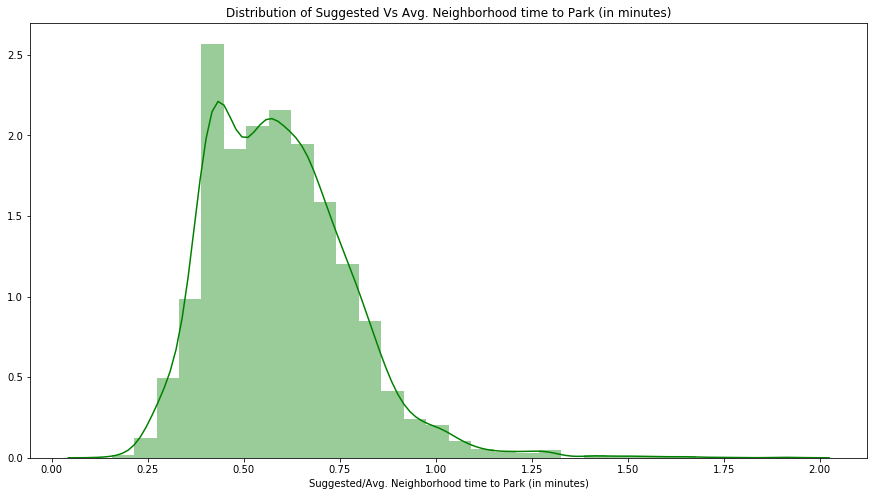

In [149]:
#Histogram of Ranking based GeoHash Park Time Vs Actual Geohash Park Time
plt.figure(figsize=(15,8))
sns.distplot(compareActPredParkTime["RecnPerfIndex"],bins=30,color="g");
plt.title("Distribution of Suggested Vs Avg. Neighborhood time to Park (in minutes)");
plt.xlabel("Suggested/Avg. Neighborhood time to Park (in minutes)");

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">Using a simple ranking algorithm of different features considered, our suggestion can lead to much reduced park time than the current scenario. </font> </p>

In [143]:
# How does the recommended geohash compare to own geohash park time?
compareActPredParkTime=compareActPredParkTime.merge(geoTabDat[['Geohash','AvgTimeToPark']],left_on='spendGeoHash',right_on='Geohash')

In [144]:
compareActPredParkTime=compareActPredParkTime.drop(['Geohash'],axis=1)

In [145]:
compareActPredParkTime.columns=['spendGeoHash', 'Act_Avg_ParkTime', 'Rec_parkGeoHash', 'Rec_ParkTime','RecnPerfIndex', 'Own_AvgTimeToPark']

In [146]:
compareActPredParkTime['OwnRecnPerfIndex']=compareActPredParkTime['Rec_ParkTime']/compareActPredParkTime['Own_AvgTimeToPark']

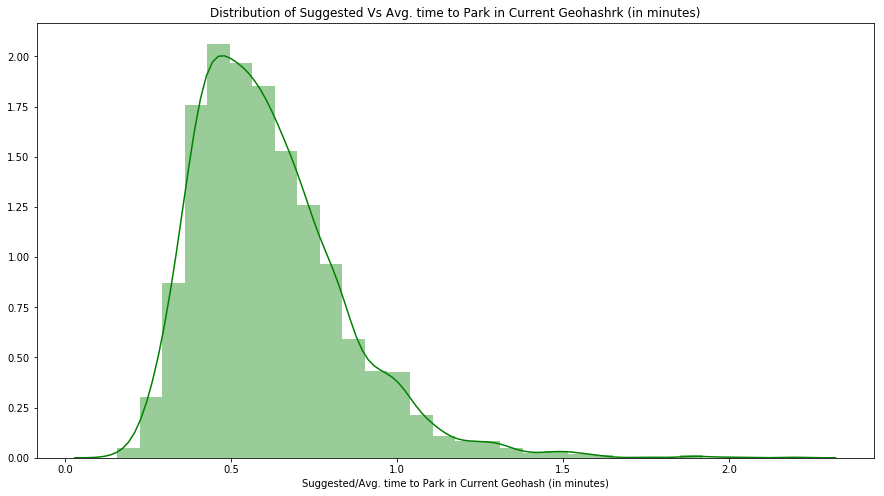

In [150]:
plt.figure(figsize=(15,8))
sns.distplot(compareActPredParkTime["OwnRecnPerfIndex"],bins=30,color="g");
plt.title("Distribution of Suggested Vs Avg. time to Park in Current Geohashrk (in minutes)");
plt.xlabel("Suggested/Avg. time to Park in Current Geohash (in minutes)");

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">In this case too, the ranking based geohash is much better than own geo hash park time. </font></p>

### II. General organization: Where to place new parking facilities?

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">In order to be able to suggest to municipalities as to how to reduce parking time at a particular geohash, we first build a model using features that explain the variance in park time across geohashes. We evaluate the prediction accuracy of the model and use this model with number of parking slots as a feature to see, how increasing the number of parking slots in a particular Geohash would change the parking time of that location.</font></p>

#### Modelling: 

In [151]:
#result=result.dropna(subset=['AvgTimeToPark'])
result=result.fillna(0)
train_data,test_data,train_pred,test_pred=train_test_split(result[['TotalSearching', 'PercentSearching','AvgUniqueGeohashes', 'AvgTotalGeohashes','PercentCar','PercentMPV','PercentLDT','PercentMDT','PercentHDT','PercentOther','food_count','shop_count','8hr_Vehicle_Vol','8hr_Pedestrian_Vol']],result[['AvgTimeToPark']], test_size=0.25, random_state=42)

In [152]:
random_state = 42
n_jobs = 1
n_estimators = 1000
step_factor = 10
axis_step = int(n_estimators/step_factor)
estimators = np.zeros(axis_step)
rf_mse = np.zeros(axis_step)
for i in range(0, axis_step):
    #print("Random Forest Estimator: %d of %d..." % (
    #    step_factor*(i+1), n_estimators)
   # )
    fit_rf = RandomForestRegressor(
        n_estimators=step_factor*(i+1),
        n_jobs=n_jobs,
        random_state=random_state
    )
    fit_rf.fit(train_data, train_pred)
    mse = mean_squared_error(test_pred,fit_rf.predict(test_data))
    estimators[i] = step_factor*(i+1)
    rf_mse[i] = mse

<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">The below plot illustrates the performance of a random forest model as we increase the number of trees in the forest and we observe that the lowest MSE is at 240. </font> </p>

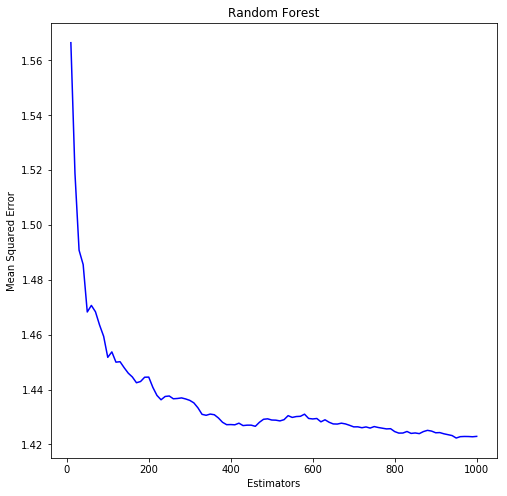

In [154]:
plt.figure(figsize=(8, 8))
plt.title('Random Forest')

plt.plot(estimators, rf_mse, 'b-', color="blue")

plt.xlabel('Estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [155]:
data = df_cor.iloc[:, df_cor.columns != 'AvgTimeToPark']
pred = df_cor.iloc[:, df_cor.columns == 'AvgTimeToPark']
feature_list = list(data.columns)
data_ = np.array(data)
pred_ = np.array(pred)
train_data, test_data, train_pred, test_pred = train_test_split(data_, pred_,test_size = 0.25, random_state = 42)
fit_rf = RandomForestRegressor(n_estimators= 240, random_state=100)
fit_rf.fit(train_data, train_pred)
predictions = fit_rf.predict(test_data)
# Performance metrics
errors = abs(predictions - test_pred)
print('Random Forest Performance Accuracy')
print('Average absolute error:', round(np.mean(errors), 2))
mse = mean_squared_error(test_pred,predictions)
print('Mean square error:', round(mse, 2))
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / test_pred))
# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Random Forest Performance Accuracy
Average absolute error: 1.29
Mean square error: 1.41
Accuracy: 73.54 %.


<p style="text-align:justify"><font size="2.5" style="font-family:helvetica">
    <b>Conclusion:</b>
Random forest has a performance accuracy of 74% with a MSE of 1.41 minutes for our dataset
    </font></p>

#### Feature Importance

In [156]:
# Get numerical feature importances
importances = list(fit_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
feature_importances_dat=pd.DataFrame(feature_importances)
feature_importances_dat.columns=['Feature','Importance']
feature_importances_dat

,Feature,Importance
0,AvgTotalGeohashes,0.21
1,PercentSearching,0.17
2,food_count,0.10
3,8hr_Pedestrian_Vol,0.09
4,AvgUniqueGeohashes,0.07
5,PercentMPV,0.05
6,PercentHDT,0.05
7,shop_count,0.05
8,8hr_Vehicle_Vol,0.05
9,TotalSearching,0.04


<p style="text-align:justify"><font size="2.5" style="font-family:helvetica"> We further reduce the feature set  to only the top 5 features identified by the model and re-build model and observe accuracy. It can be seen that, top 5 features can achieve an accuracy of about 73% in predicting the Avg. time taken to park for a geohash </font> </p>

In [157]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:5]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_train_data = train_data[:, important_indices]
important_test_data = test_data[:, important_indices]

In [158]:
rf_exp = RandomForestRegressor(n_estimators= 240, random_state=100)
# Train the expanded model on only the important features
rf_exp.fit(important_train_data, train_pred);
# Make predictions on test data
predictions = rf_exp.predict(important_test_data)
# Performance metrics
errors = abs(predictions - test_pred)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_pred)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 1.31 degrees.
Accuracy: 73.35 %.


# Next Steps <a class="anchor" id="fifth-bullet"></a>

<p style="text-align:justify"><font size="3" style="font-family:helvetica">
<br></br>
    <b>1. Individual Vehicles:</b><br></br>
    a. Include no. of parking slots available and hourly distribution as features<br></br>
    b. Build a classificiation model to predict if a geohash neighbor is the likely choice to park from the current geohash given the values for identified features.<br></br>
    Description: To do this, we generate all possible combination of geohash dataset and mark as 1 only those pairs in which vehicles have driven into to park, historically and then build a classification model to predict the same.<br></br>
    Outcome: Likelihood to find a parking spot in a particular geohash.<br></br>
<br></br>    
<b>2. General Organization:</b><br></br>
        a. Include no. of parking slots available and hourly distribution as features<br></br>
        b. Evaluate multiple regression performance against random forest technique<br></br>
        c. Define a distribution for no.of parking slots in a geohash and study how disitrbution of parking time varies across geohashes
<br></br>
</p>